Copied over from test_modelling.ipynb after having issues with greying out background and outputs being covered. Copied to new notebook per this issue resolution: https://github.com/microsoft/vscode/issues/146153

<br>
Note: I have now also removed the attrs dependency issue by uninstalling nemseer.

<br>
The speed issue with VSCode and Jupyter Notebooks (+occasional crashing): disabled Pylance, reverted to a late-2023 version of Jupyter to see what difference it makes (per this thread: https://github.com/microsoft/vscode-jupyter/issues/15351)

In [1]:
# ------------------------------ Packages & Files ------------------------------
import pandas as pd
import numpy as np
import os

import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import nemed
import ppa, residuals, tariffs, hybrid, firming_contracts, load_flex, battery
import calendar
import holidays
import pprint
import logging
from pathlib import Path
from scipy.stats import norm
from random import random
from datetime import timedelta, datetime

from nemosis import dynamic_data_compiler, static_table
from getting_data import import_gen_data, import_load_data, import_pricing_data, import_emissions_data
from helper_functions import _check_interval_consistency, _check_missing_data, get_interval_length

from mip import Model, xsum, minimize, CONTINUOUS, BINARY, OptimizationStatus

logging.getLogger("nemosis").setLevel(logging.WARNING)
logging.getLogger("nemed").setLevel(logging.WARNING)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

INFO: Using Python-MIP package version 1.15.0


In [2]:
# -------------------------------- USER INPUTS ---------------------------------
# - - - - - - - - - - - - - - - - - - DATA - - - - - - - - - - - - - - - - - - -

# load data file name
load_fn = ''
LOAD_COL_NAME = 'Load'
LOAD_TIMEZONE = ''

# generation data file name, or, generator DUID(s)
# TODO: add function to take input TYPE of generator and select appropriate trace
GEN_FN = ''
GEN_COL_NAME_S = ''

# get name of datetime column for both load and generation files
LOAD_DATETIME_COL_NAME = 'TS'
GEN_DATETIME_COL_NAME = ''
DAY_FIRST = True
GEN_TECH_TYPE_S = ['WIND - ONSHORE', 'PHOTOVOLTAIC FLAT PANEL']

# Region to fetch generation/pricing/emissions data for, and the region in which 
# the load is located:
GENERATOR_REGION = 'QLD1'
LOAD_REGION = 'QLD1'

# NEMOSIS inputs:
RAW_DATA_CACHE = 'data_caches/gen_data_cache'
EMISSIONS_CACHE = 'data_caches/nemed_cache'
PRICING_CACHE = 'data_caches/pricing_cache'


# - - - - - - - - - - - - - - - - - CONTRACT - - - - - - - - - - - - - - - - - -
# TODO: fill out
DELIVERY_STRUCTURE = ''
FIRMING_CONTRACT_TYPE = 'Partially wholesale exposed'

EXPOSURE_BOUND_UPPER = 300
EXPOSURE_BOUND_LOWER = 20
RETAIL_TARIFF_DETAILS = {'a':'b'}

FLOOR_PRICE = 0.0

In [3]:
# Provide artificial start and end dates so we can loop over load later:
start_date = datetime.strptime('2020-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime('2023-12-31 23:00:00', '%Y-%m-%d %H:%M:%S')

# ----------------------------- Get Generation Data ----------------------------
gen_data = import_gen_data.get_generation_data(RAW_DATA_CACHE, GENERATOR_REGION, GEN_TECH_TYPE_S, start_date=start_date, end_date=end_date)

# ------------------------ Get Pricing & Emissions Data ------------------------
emissions_intensity = import_emissions_data.get_avg_emissions_intensity(
    start_date, end_date, EMISSIONS_CACHE, [LOAD_REGION, GENERATOR_REGION]
)

price_data = import_pricing_data.get_wholesale_price_data(
    start_date, end_date, PRICING_CACHE, [LOAD_REGION, GENERATOR_REGION]
)

Some missing data found. Filled with zeros.



In [17]:
earlier_price_data = import_pricing_data.get_wholesale_price_data(
    datetime.strptime('2019-01-01 00:00:00', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2019-12-31 00:00:00', '%Y-%m-%d %H:%M:%S'), PRICING_CACHE, [LOAD_REGION, GENERATOR_REGION]
)

earlier_price_data_annual_average = earlier_price_data.copy().resample('Y').mean(numeric_only=True)
earlier_price_data_solar_hours = earlier_price_data.copy().between_time('7:00', '17:00', inclusive='both')
earlier_price_data_solar_avg = earlier_price_data_solar_hours.resample('Y').mean(numeric_only=True)

print(earlier_price_data_annual_average.values, earlier_price_data_solar_avg.values)

[[71.70087027]] [[67.54714805]]


In [5]:
solar_1 = 'DDSF1: PHOTOVOLTAIC FLAT PANEL'
solar_2 = 'SMCSF1: PHOTOVOLTAIC FLAT PANEL'
wind_1 = 'MEWF1: WIND - ONSHORE'
wind_2 = 'COOPGWF1: WIND - ONSHORE'


gen_data = gen_data.rename(columns = {col : col.upper() for col in gen_data.columns})
gen_data = gen_data[[solar_1, solar_2, wind_1, wind_2]]

In [39]:
# -------- SIMPLE LCOE CALCULATIONS ----------

# Low assumption from GenCost 2018
lcoe_info_dict = {
    solar_1 : {
        'Nameplate Capacity (kW)' : 110000,
        'Fixed O&M ($/kW)': 14.4,
        'Variable O&M ($/kWh)' : 0.0,
        'Capital ($/kW)' : 1280,
        'Capacity Factor' : 0.22
    },
    solar_2 : {
        'Nameplate Capacity (kW)' : 125000,
        'Fixed O&M ($/kW)': 14.4,
        'Variable O&M ($/kWh)' : 0.0,
        'Capital ($/kW)' : 1280,
        'Capacity Factor' : 0.22
    },
    wind_1 : {
        'Nameplate Capacity (kW)' : 180000,
        'Fixed O&M ($/kW)': 36.0,
        'Variable O&M ($/kWh)' : 2.7/1000,
        'Capital ($/kW)' : 2005,
        'Capacity Factor' : 0.35
    },
    wind_2 : {
        'Nameplate Capacity (kW)' : 453000,
        'Fixed O&M ($/kW)': 36.0,
        'Variable O&M ($/kWh)' : 2.7/1000,
        'Capital ($/kW)' : 2005,
        'Capacity Factor' : 0.35
    }
}

for generator, info in lcoe_info_dict.items():
    capital_cost_year_one = info['Capital ($/kW)'] * (info['Nameplate Capacity (kW)'] * 1000)
    lifetime_years = 25
    discount_rate = 0.07        # AEMC uses 6-8.5% for all technologies

    numerator = 0.0
    denominator = 0.0
    capital_year_n = capital_cost_year_one
    for year in range(0, lifetime_years):
        capital_year_n = (capital_cost_year_one) * (year == 0)
        kwh_in_year_n = (info['Capacity Factor'] * info['Nameplate Capacity (kW)'] * (365*24))
        numerator += (capital_year_n + info['Fixed O&M ($/kW)']*info['Nameplate Capacity (kW)'] + info['Variable O&M ($/kWh)']*kwh_in_year_n) / ((1 + discount_rate)**year)
        denominator += (kwh_in_year_n) / ((1 + discount_rate)**year)

    final = numerator / denominator

    print(final)

53.27222586370623
53.27222586370621
52.458823241166186
52.458823241166165


In [5]:
# At this point: loop through the loads, create a big df with results for each
# Key results at this point: percentage mix of each generator, matching percent.
from os.path import isfile

dir = '/Users/elliekallmier/Desktop/RA_Work/247/247_ppa/five_year_data'

results = pd.DataFrame()
for file in os.listdir(dir):
    if file[-1] == 'v':
        filepath = dir + '/' + file
        load_data, start_date, end_date = import_load_data.get_load_data(filepath, LOAD_DATETIME_COL_NAME, LOAD_COL_NAME, DAY_FIRST)
        load_data = load_data / 1000    # convert to MWh
        load_data = load_data[load_data.index >= '2020-01-01 00:00:00']

        one_yr_gen = gen_data.iloc[:24*365].copy().sum()
        one_yr_load = load_data.iloc[:24*365].copy().sum()
        gen_data_test = gen_data.copy()

        for gen in gen_data_test.columns:
            gen_data_test[gen] = gen_data_test[gen] * (one_yr_load['Load'] / one_yr_gen[gen])

        gen_info = {
            wind_1 : 75,
            solar_1 : 65
        }

        combined_data = pd.concat([load_data, gen_data_test, price_data, emissions_intensity], axis='columns')
        combined_data = combined_data.dropna(how='any', axis='rows')

        combined_data_firming = firming_contracts.choose_firming_type(
            FIRMING_CONTRACT_TYPE, combined_data, [LOAD_REGION], EXPOSURE_BOUND_UPPER, EXPOSURE_BOUND_LOWER, RETAIL_TARIFF_DETAILS
        )

        try:
            opt_hybrid, percentages = hybrid.create_hybrid_generation('Pay as Produced', 'M',  100, combined_data_firming, LOAD_REGION, gen_info, '60', 0.75)

            results.loc[file, wind_1] = percentages[wind_1]['Percent of hybrid trace']
            results.loc[file, solar_1] = percentages[solar_1]['Percent of hybrid trace']
            
        except:
            print('Optimisation didnt work')    

Some missing data found. Filled with zeros.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Some missing data found. Filled with zeros.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Some missing data found. Filled with zeros.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Some missing data found. Filled with zeros.

Set parameter Username
Academic license 

In [6]:
# Renaming files once loaded in for prettiness:

renaming_dict = {}
i = 0
while i < len(results.index):
    new_name = input(f'{results.index[i]}: ')
    renaming_dict[results.index[i]] = new_name

    i += 1

In [9]:
renames = {}
for name, new_name in renaming_dict.items():
    number = name.split('_')[1]

    new_new_name = new_name + ' ' + number
    renames[name] = new_new_name

print(renames)


{'Sewerage treatment_57_FN_same_year.csv': 'Sewerage Treatment (FN) 57', 'Engineering office_65_FN.csv': 'Engineering Office (FN) 65', 'Food processing_87_WB_same_year.csv': 'Food Processing (WB) 87', 'Refrigeration warehouse_28_SW_same_year.csv': 'Refrigeration Warehouse (SW) 28', 'Engineering-Metal and non-metal fabrications_86_SW_same_year.csv': 'Engineering Metal and Non-metal Fabrications (SW) 86', 'Manufacturer_50_CA_same_year.csv': 'Manufacturer (CA) 50', 'Port facility_70_FN_same_year.csv': 'Port Facility (FN) 70', 'sa_manufacturing_data.csv': 'SA Manufacturing (AGL) manufacturing', 'Offices_48_NQ_same_year.csv': 'Offices (NQ) 48', 'Foundry_27_FN_same_year.csv': 'Foundry (FN) 27', 'Resort_25_FN.csv': 'Resort (FN) 25', 'Office building_54_FN.csv': 'Office Building (FN) 54', 'Recycling centre_58_FN_same_year.csv': 'Recycling Centre (FN) 58', 'Office building_83_SW_same_year.csv': 'Office Building (SW) 83', 'Sugar Mill (load)_85_NQ_same_year.csv': 'Sugar Mill (NQ) 85', 'Offices_24

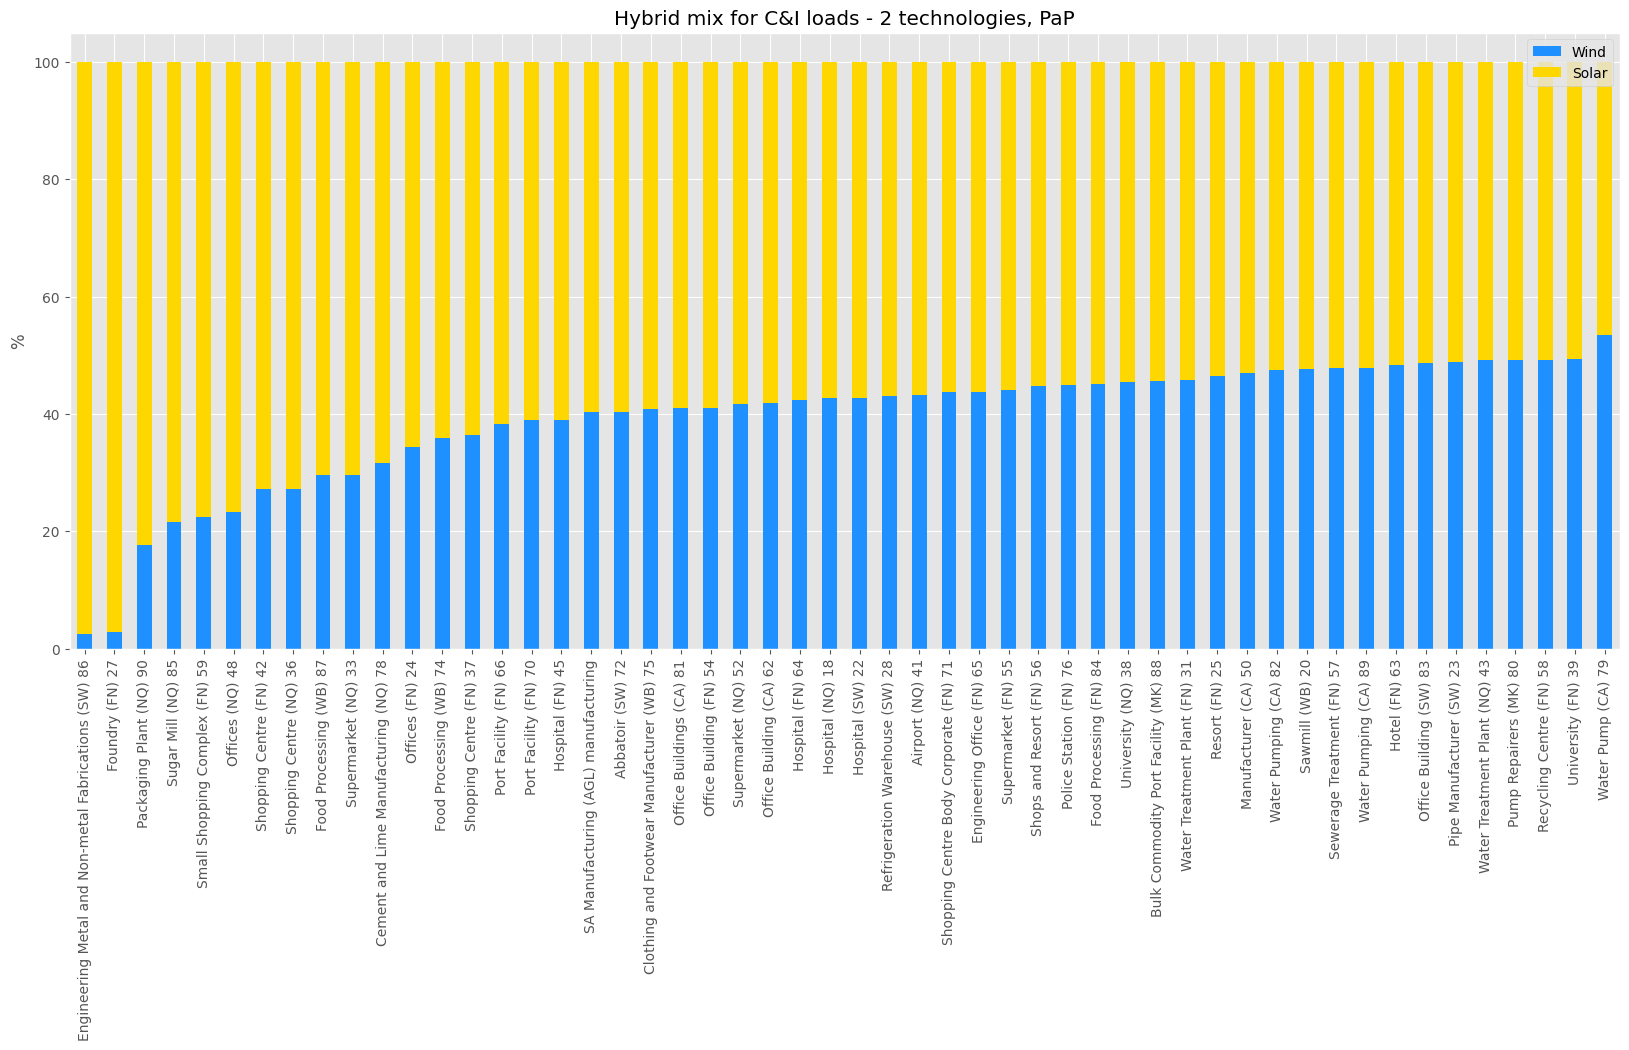

In [12]:
results = results.rename(columns={'MEWF1: WIND - ONSHORE': 'Wind', 'DDSF1: PHOTOVOLTAIC FLAT PANEL' : 'Solar'}, index=renames)
# results['Name'] = results.index.str.split('.').str[0]
# results.index = results['Name']

results = results.sort_values(by='Wind')

# fig = plt.figure(figsize=(16, 8))
results.plot(kind='bar', stacked=True, figsize=(20,8), color=['dodgerblue', 'gold'])
plt.title('Hybrid mix for C&I loads - 2 technologies, PaP')
plt.ylabel('%')
plt.show()

In [13]:
results_2 = pd.DataFrame()
for file in os.listdir(dir):
    if file[-1] == 'v':
        filepath = dir + '/' + file
        load_data, start_date, end_date = import_load_data.get_load_data(filepath, LOAD_DATETIME_COL_NAME, LOAD_COL_NAME, DAY_FIRST)
        load_data = load_data / 1000    # convert to MWh

        one_yr_gen = gen_data.iloc[:24*365].copy().sum()
        one_yr_load = load_data.iloc[:24*365].copy().sum()
        gen_data_test = gen_data.copy()

        for gen in gen_data_test.columns:
            gen_data_test[gen] = gen_data_test[gen] * (one_yr_load['Load'] / one_yr_gen[gen])

        combined_data = pd.concat([load_data, gen_data_test, price_data, emissions_intensity], axis='columns')
        combined_data = combined_data.dropna(how='any', axis='rows')

        combined_data_firming = firming_contracts.choose_firming_type(
            FIRMING_CONTRACT_TYPE, combined_data, [LOAD_REGION], EXPOSURE_BOUND_UPPER, EXPOSURE_BOUND_LOWER, RETAIL_TARIFF_DETAILS
        )

        gen_info = {
            wind_1 : 75,
            solar_1 : 65,
            wind_2 : 72
        }

        try:
            opt_hybrid, percentages = hybrid.create_hybrid_generation('Pay as Produced', 'M',  100, combined_data_firming, LOAD_REGION, gen_info, '60', 0.75)

            name = renames[file]

            results_2.loc[name, wind_1] = percentages[wind_1]['Percent of hybrid trace']
            results_2.loc[name, solar_1] = percentages[solar_1]['Percent of hybrid trace']
            results_2.loc[name, wind_2] = percentages[wind_2]['Percent of hybrid trace']
            
        except:
            print('Optimisation didnt work')

Some missing data found. Filled with zeros.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Some missing data found. Filled with zeros.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Some missing data found. Filled with zeros.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Some missing data found. Filled with zeros.

Set parameter Username
Academic license 

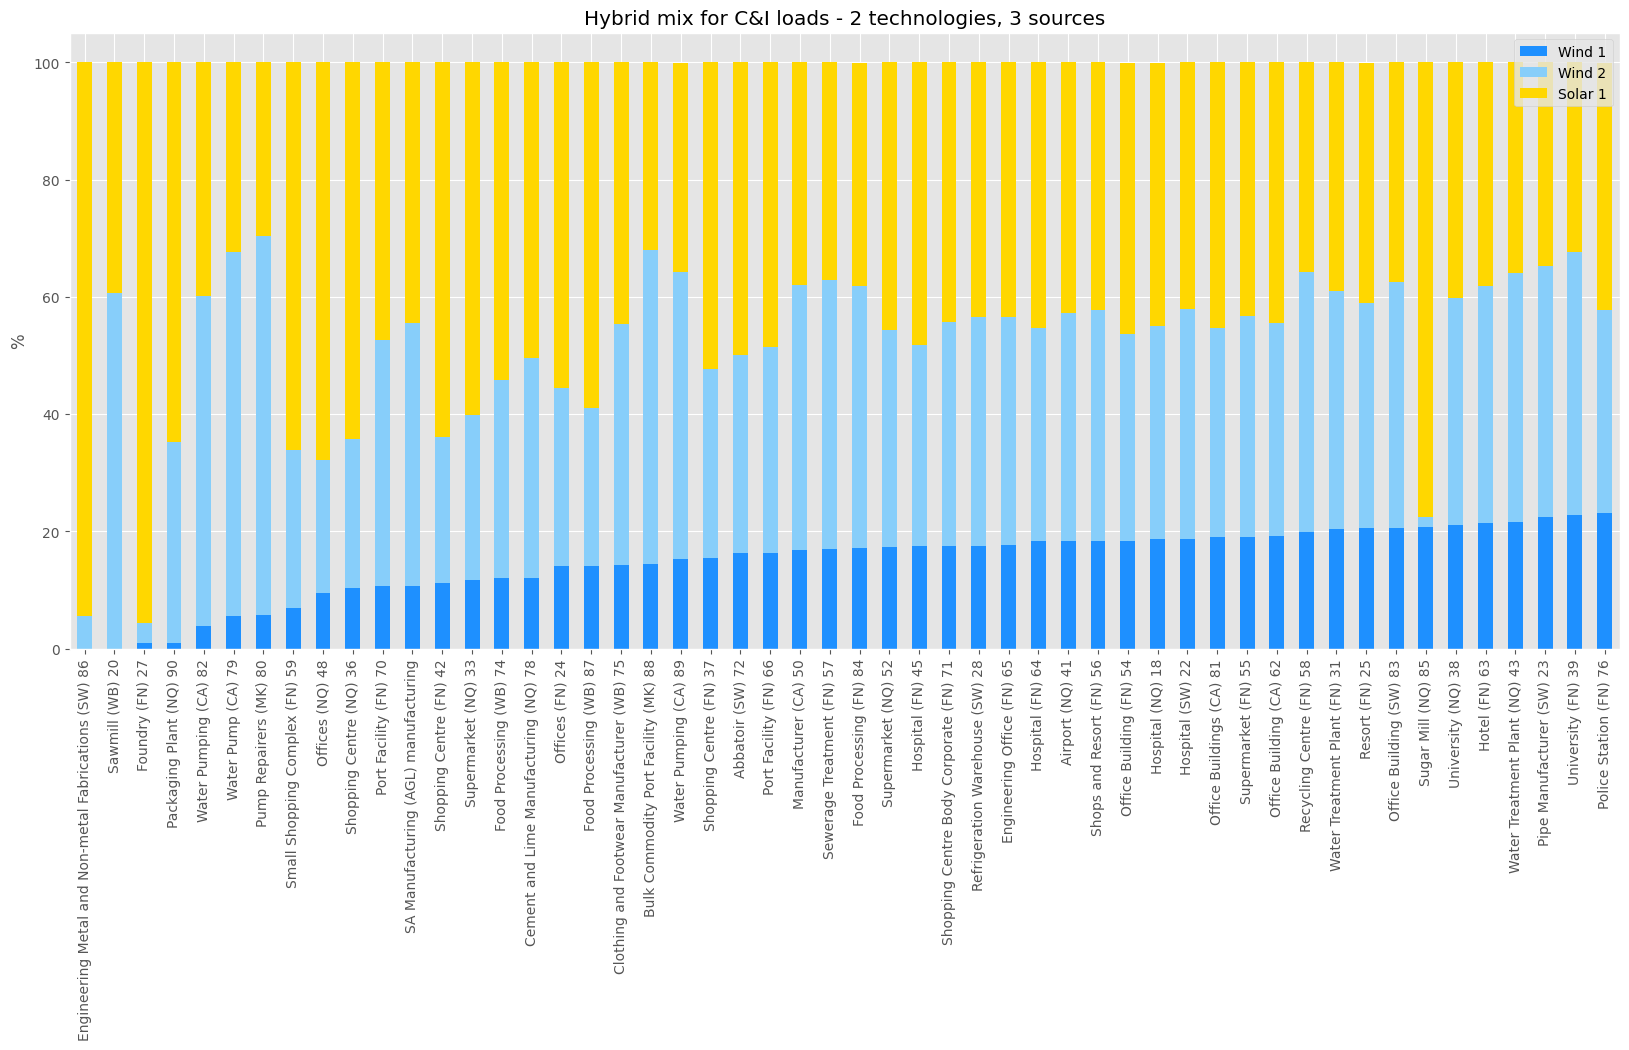

In [14]:
results_2 = results_2.rename(columns={'MEWF1: WIND - ONSHORE': 'Wind 1', 'DDSF1: PHOTOVOLTAIC FLAT PANEL' : 'Solar 1', 'COOPGWF1: WIND - ONSHORE' : 'Wind 2'})
# results_2['Name'] = results_2.index.str.split('.').str[0]
# results_2.index = results_2['Name']

results_2 = results_2.sort_values(by=['Wind 1', 'Wind 2'])
results_2 = results_2[['Wind 1', 'Wind 2', 'Solar 1']]

# fig = plt.figure(figsize=(16, 8))
results_2.plot(kind='bar', stacked=True, figsize=(20,8), color=['dodgerblue', 'lightskyblue', 'gold'])
plt.title('Hybrid mix for C&I loads - 2 technologies, 3 sources')
plt.ylabel('%')
plt.show()

In [15]:
# Helper function to calculate yearly indexation:
def yearly_indexation(
        df:pd.DataFrame,
        strike_price:float,
        indexation:float|list[float]
) -> pd.DataFrame:
    
    years = df.index.year.unique()
    
    # If the value given for indexation is just a float, or the list isn't as long
    # as the number of periods, keep adding the last element of the list until
    # the length is correct.
    if type(indexation) != list:
        indexation = [indexation] * len(years)

    while len(indexation) < len(years):
        indexation.append(indexation[-1])

    spi_map = {}
    for i, year in enumerate(years):
        spi_map[year] = strike_price
        strike_price += strike_price * indexation[i]/100

    spi_map[year] = strike_price

    df_with_strike_price = df.copy()

    df_with_strike_price['Strike Price (Indexed)'] = df_with_strike_price.index.year
    df_with_strike_price['Strike Price (Indexed)'] = df_with_strike_price['Strike Price (Indexed)'].map(spi_map)

    return df_with_strike_price['Strike Price (Indexed)']


def quarterly_indexation(
        df:pd.DataFrame,
        strike_price:float,
        indexation:float|list[float]
) -> pd.DataFrame:
    
    years = df.index.year.unique()

    quarters = [(year, quarter) for year in years for quarter in range(1, 5)]

    # If the value given for indexation is just a float, or the list isn't as long
    # as the number of periods, keep adding the last element of the list until
    # the length is correct.
    if type(indexation) != list:
        indexation = [indexation] * len(quarters)

    while len(indexation) < len(quarters):
        indexation.append(indexation[-1])

    spi_map = {}
    for i, quarter in enumerate(quarters):
        spi_map[quarter] = strike_price
        strike_price += strike_price * indexation[i]/100

    spi_map[quarter] = strike_price

    df_with_strike_price = df.copy()

    tuples = list(zip(df_with_strike_price.index.year.values, df_with_strike_price.index.quarter.values))

    df_with_strike_price['Strike Price (Indexed)'] = tuples
    df_with_strike_price['Strike Price (Indexed)'] = df_with_strike_price['Strike Price (Indexed)'].map(spi_map)

    return df_with_strike_price['Strike Price (Indexed)']


# Functions to calculate the PPA cost outcomes under each contract type:
def calculate_ppa(
        df:pd.DataFrame,
        load_region:str,
        strike_price:float,
        settlement_period:str,
        indexation:float|list[float]=0, # set a default for no indexation, for simplicity
        index_period:str='Y',   # and default period is yearly for slightly faster calcs just in case
        floor_price:float=-1000.0,  # default value is market floor
) -> pd.DataFrame:

    # add indexed strike_price column to df:
    indexation_calc = {'Y':yearly_indexation, 'Q':quarterly_indexation}
    strike_prices_indexed = indexation_calc[index_period](df, strike_price, indexation)
    
    df['Strike Price (Indexed)'] = strike_prices_indexed.copy()

    # settle around the contracted energy: strike_price - max(RRP, floor_price)
    df['Price'] = (df['Strike Price (Indexed)'] - np.maximum(df[f'RRP: {load_region}'], floor_price))
    df['PPA Settlement'] = df['Contracted Energy'] * (df['Strike Price (Indexed)'] - np.maximum(df[f'RRP: {load_region}'], floor_price))
    df['PPA Value'] = df['Strike Price (Indexed)'] * df['Contracted Energy']

    df_resamp = df.resample(settlement_period).sum(numeric_only=True).copy()

    return df_resamp


# Returns a TIMESERIES df
def calculate_excess_electricity(
        df:pd.DataFrame,
        load_region:str,
        settlement_period:str,
        excess_price:float|str='Wholesale'  # need to validate this input
) -> pd.DataFrame:
        # then selling any excess energy (contracted, but not used by the buyer) - keeping LGCs associated if bundled!!!
    # excess price is determined as either wholesale prices or a fixed price.
    if type(excess_price) == str and excess_price != 'Wholesale':
        raise ValueError('excess_price should be one of "Wholesale" or a float representing the fixed on-sell price.')

    if excess_price == 'Wholesale':
        df['Excess Price'] = df[f'RRP: {load_region}'].copy()
    else:
        df['Excess Price'] = excess_price

    df['Excess Energy'] = (df['Contracted Energy'] - df['Load']).clip(lower=0.0)
    df['Excess Energy Revenue'] = df['Excess Energy'] * df['Excess Price']

    df_resamp = df.resample(settlement_period).sum(numeric_only=True).copy()

    return df_resamp


# Returns a RESAMPLED DF to the settlement period: not interval timeseries data
def calculate_shortfall(
        df:pd.DataFrame,
        settlement_period:str,
        contract_type:str,
        shortfall_penalty:float,       # Penalty to be paid for shortfall energy - "shortfall damages"
        guaranteed_percent:float,     # A percentage of load in each settlement period to contract.
) -> pd.DataFrame:
    
    allowed_periods = {'Y', 'Q', 'M'}
    if settlement_period not in allowed_periods:
        raise ValueError(f'settlement_period should be one of {allowed_periods}.')

    # resample to each period
    # find the difference between contracted amount and delivered amount in each period
    df_resamp = df.resample(settlement_period).sum(numeric_only=True).copy()

    if contract_type in ['Pay as Produced', 'Pay as Consumed']:
        df_resamp['Guaranteed Energy'] = df_resamp['Load'] * guaranteed_percent/100
        df_resamp['Shortfall'] = (df_resamp['Guaranteed Energy'] - df_resamp['Contracted Energy']).clip(lower=0.0)
        df_resamp['Shortfall'] *= shortfall_penalty

    elif contract_type in ['Baseload', 'Shaped']:
        df['Shortfall'] = (df['Contracted Energy'] - df['Hybrid']).clip(lower=0.0)
        df['Shortfall'] *= shortfall_penalty         # IF the seller contracts other "Replacement Energy" - set shortfall penalty to zero.
        df_resamp = df.resample(settlement_period).sum(numeric_only=True).copy()
        
    else:
        # 24/7 PPA shortfall is based on the match % (CFE score) - if actual match < contracted % on average in each period, penalty applies to the missing %
        df_resamp_247 = df.copy()
        df_resamp_247['Match %'] = 0
        df_resamp_247['Match %'] = np.where(df_resamp_247['Load'] == 0, 100, np.minimum(df_resamp_247['Contracted Energy'] / df_resamp_247['Load'] * 100, 100))
        df_resamp_247 = df_resamp_247.resample(settlement_period).mean(numeric_only=True)
        df_resamp_247['Shortfall %'] = (guaranteed_percent - df_resamp_247['Match %']).clip(lower=0.0)

        df_resamp = pd.concat([df_resamp, df_resamp_247['Shortfall %']], axis='columns')
        df_resamp['Shortfall'] = df_resamp['Load'] * df_resamp['Shortfall %']/100 * shortfall_penalty

    return df_resamp


# Returns RESAMPLED df to settlement period.
def calculate_lgcs(
    df:pd.DataFrame,
    settlement_period:str,
    lgc_buy_price:float,
    lgc_sell_price:float,
    guaranteed_percent:float
) -> pd.DataFrame:

    allowed_periods = {'Y', 'Q', 'M'}
    if settlement_period not in allowed_periods:
        raise ValueError(f'settlement_period should be one of {allowed_periods}.')

    df_to_check = df[['Load', 'Contracted Energy']].copy()

    # Find the short and long positions for each settlement period - this informs
    # the need for penalties, purchases or sales.
    # Note: checking against the contract
    df_to_check = df_to_check.resample(settlement_period).sum(numeric_only=True)
    df_to_check['Volume Difference'] = df_to_check['Load']*(guaranteed_percent/100) - df_to_check['Contracted Energy']
    
    # Volume difference tells how much under/over the amount of contracted load the generation in this period is
    # The handling of these values depends on the PPA type!
    df_to_check['LGC Undersupply'] = np.where(df_to_check['Volume Difference'] > 0, df_to_check['Volume Difference'], 0.0)
    df_to_check['LGC Oversupply'] = np.where(df_to_check['Volume Difference'] < 0, df_to_check['Volume Difference'], 0.0)

    df_to_check['LGC Undersupply'] *= lgc_buy_price
    df_to_check['LGC Oversupply'] *= lgc_sell_price

    return df_to_check


def calculate_bill(
        df:pd.DataFrame,
        settlement_period:str,
        contract_type:str,
        load_region:str,
        strike_price:float,
        lgc_buy_price:float=0.0,                # Default values for all shortfall and LGC sale/purchase is $0 (so default is no penalties, no balancing).
        lgc_sell_price:float=0.0,
        shortfall_penalty:float=0.0,
        guaranteed_percent:float=100.0,
        excess_price:float|str='Wholesale',
        indexation:float|list[float]=0,         # set a default for no indexation, for simplicity
        index_period:str='Y',                   # and default period is yearly for slightly faster calcs just in case
        floor_price:float=-1000.0,              # default value is market floor
) -> pd.DataFrame:
    # put everything together here:
    # 1. PPA settlement costs
    # 2. Firming costs 
    # 3. Revenue from on-sold excess RE
    # 4. Purchase of extra LGCs
    # 5. Sale of excess LGCs
    # 6. Any shortfall penalty payments for LGCs or generation

    results = pd.DataFrame()

    # 1. PPA settlement costs: 
    ppa_costs = calculate_ppa(df, load_region, strike_price, settlement_period, indexation, index_period, floor_price)
    results['PPA Value'] = ppa_costs['PPA Value'].copy()
    results['PPA Settlement'] = ppa_costs['PPA Settlement'].copy()

    # 2. Firming costs: TODO: call FIRMING_FUNCTION here!!!
    firming_costs = df.copy()
    firming_costs['Unmatched Energy'] = (firming_costs['Load'] - firming_costs['Contracted Energy']).clip(lower=0.0)
    firming_costs['Firming Costs'] = firming_costs['Unmatched Energy'] * firming_costs[f'Firming price: {load_region}']
    firming_costs = firming_costs.resample(settlement_period).sum(numeric_only=True)

    results['Firming Costs'] = firming_costs['Firming Costs'].copy()

    # 3. Revenue from on-sold excess RE:
    excess_val = calculate_excess_electricity(df, load_region, settlement_period, excess_price)
    results['Revenue from on-sold RE'] = -1 * excess_val['Excess Energy Revenue'].copy()

    # 4. and 5. Revenue/Cost of LGCs
    lgc_balance = calculate_lgcs(df, settlement_period, lgc_buy_price, lgc_sell_price, guaranteed_percent)
    results['Revenue from excess LGCs'] = lgc_balance['LGC Oversupply'].copy()
    results['Cost of shortfall LGCs'] = lgc_balance['LGC Undersupply'].copy()

    # 6. Shortfall payments for energy - applied based on contract type.
    shortfall_payment_received = calculate_shortfall(df, settlement_period, contract_type, shortfall_penalty, guaranteed_percent)
    results['Shortfall Payments Received'] = -1 * shortfall_payment_received['Shortfall']

    results['Total'] = results.sum(axis='columns')

    return results


# calculate_bill(combined_data_firming, 'Y', '24/7', LOAD_REGION, strike_price=124, lgc_buy_price=35, lgc_sell_price=20, shortfall_penalty=25, guaranteed_percent=85, excess_price=65, indexation=1, index_period='Y', floor_price=0)

In [16]:
# Functions to calculate the other metrics: matching % hourly, annually, against hybrid and contracted traces, emissions outcomes

def calc_hourly_match(
        df:pd.DataFrame,
        col_to_match_to:str,
        resample_period:str,
        load_region:str
) -> pd.DataFrame:

    matching = df.copy()
    matching['Hourly Match %'] = 0
    matching['Hourly Match %'] = np.where(matching['Load']==0, 100, np.minimum(matching[col_to_match_to] / matching['Load'] * 100, 100))

    matching = matching.resample(resample_period).mean(numeric_only=True)

    return matching['Hourly Match %']

def calc_bulk_match(
        df:pd.DataFrame,
        col_to_match_to:str,
        resample_period:str,
        load_region:str
) -> pd.DataFrame:

    resampled = df.resample(resample_period).sum(numeric_only=True).copy()
    resampled['Bulk Match %'] = resampled[col_to_match_to] / resampled['Load'] * 100

    return resampled['Bulk Match %']


def calc_unmatched_emissions(
        df:pd.DataFrame,
        col_to_match_to:str,
        resample_period:str,
        load_region:str
) -> pd.DataFrame:
    
    emissions_df = df.copy()
    emissions_df['Emissions'] = (emissions_df['Load'] - emissions_df[col_to_match_to]).clip(lower=0.0) * emissions_df[f'AEI: {load_region}']
    emissions_df = emissions_df.resample(resample_period).sum(numeric_only=True)

    return emissions_df['Emissions']


# calc_unmatched_emissions(combined_data_firming, 'Contracted Energy', 'Y', LOAD_REGION)

In [17]:
from os.path import isfile

# dir = '/Users/elliekallmier/Desktop/RA_Work/247_TRUZERO/247_ppa/five_year_data'

# Find annual outcomes for the 3 technology scenario - first, with no extra management!
results_dict = {}

premiums = {
    'Pay as Produced' : 0.05,
    'Pay as Consumed' : 0.20,
    '24/7' : 0.30,
    'Baseload' : 0.25,
    'Shaped' : 0.25
}

for file in os.listdir(dir):
    results_dict[file] = {}
    for ppa_type in ['Pay as Produced', 'Pay as Consumed', '24/7', 'Baseload', 'Shaped']:
        if file[-1] == 'v':
            results_dict[file][ppa_type] = {}
            results_3 = pd.DataFrame()
            filepath = dir + '/' + file
            load_data, start_date_2, end_date_2 = import_load_data.get_load_data(filepath, LOAD_DATETIME_COL_NAME, LOAD_COL_NAME, DAY_FIRST)
            load_data = load_data / 1000    # convert to MWh

            one_yr_gen = gen_data.iloc[:24*365].copy().sum()
            one_yr_load = load_data.iloc[:24*365].copy().sum()
            gen_data_test = gen_data.copy()


            if ppa_type == 'Pay as Produced':
                for gen in gen_data_test.columns:
                    gen_data_test[gen] = gen_data_test[gen] * (one_yr_load['Load'] / one_yr_gen[gen])

            combined_data = pd.concat([load_data, gen_data_test, price_data, emissions_intensity], axis='columns')
            combined_data = combined_data.dropna(how='any', axis='rows')

            combined_data_firming = firming_contracts.choose_firming_type(
                FIRMING_CONTRACT_TYPE, combined_data, [LOAD_REGION], EXPOSURE_BOUND_UPPER, EXPOSURE_BOUND_LOWER, RETAIL_TARIFF_DETAILS
            )

            gen_info = {
                wind_1 : 61,
                wind_2 : 56,
                solar_1 : 47,
                solar_2 : 55
            }

            opt_hybrid, percentages = hybrid.create_hybrid_generation(ppa_type, 'Y',  100, combined_data_firming, LOAD_REGION, gen_info, '60', 0.7)

            results_3.loc[file, wind_1] = percentages[wind_1]['Percent of hybrid trace']
            results_3.loc[file, wind_2] = percentages[wind_2]['Percent of hybrid trace']
            results_3.loc[file, solar_1] = percentages[solar_1]['Percent of hybrid trace']
            results_3.loc[file, solar_2] = percentages[solar_2]['Percent of hybrid trace']

            results_dict[file][ppa_type]['Percentage mix'] = results_3.copy()

            strike_price = np.sum([results_3.loc[file, generator] / 100 * gen_info[generator] for generator in [wind_1, wind_2, solar_1, solar_2]]) * (1 + premiums[ppa_type])
                
            combined_data_firming['Hybrid'] = opt_hybrid['Hybrid'].copy()

            if 'Contracted Energy' in opt_hybrid.columns:
                combined_data_firming['Contracted Energy'] = opt_hybrid['Contracted Energy'].copy()

            else:
                combined_data_firming['Contracted Energy'] = opt_hybrid['Hybrid'].copy()

            bill_results = calculate_bill(combined_data_firming, settlement_period='Y', contract_type=ppa_type, load_region=LOAD_REGION, strike_price=strike_price, floor_price=0.0)

            emissions_results = calc_unmatched_emissions(combined_data_firming, col_to_match_to='Contracted Energy', resample_period='Y', load_region=LOAD_REGION).rename('Firming Emissions (contr.)')
            matching_bulk = calc_bulk_match(combined_data_firming, col_to_match_to='Contracted Energy', resample_period='Y', load_region=LOAD_REGION).rename('Total Match (contr.)')
            matching_hourly = calc_hourly_match(combined_data_firming, col_to_match_to='Contracted Energy', resample_period='Y', load_region=LOAD_REGION).rename('Hourly Match (contr.)')


            emissions_results_hyb = calc_unmatched_emissions(combined_data_firming, col_to_match_to='Hybrid', resample_period='Y', load_region=LOAD_REGION).rename('Firming Emissions (hybrid)')
            matching_bulk_hyb = calc_bulk_match(combined_data_firming, col_to_match_to='Hybrid', resample_period='Y', load_region=LOAD_REGION).rename('Total Match (hybrid)')
            matching_hourly_hyb = calc_hourly_match(combined_data_firming, col_to_match_to='Hybrid', resample_period='Y', load_region=LOAD_REGION).rename('Hourly Match (hybrid)')

            all_results = pd.concat([bill_results, emissions_results, emissions_results_hyb, matching_bulk, matching_bulk_hyb, matching_hourly, matching_hourly_hyb], axis='columns')

            results_dict[file][ppa_type]['All Results'] = all_results.copy()

    break




Some missing data found. Filled with zeros.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Some missing data found. Filled with zeros.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Some missing data found. Filled with zeros.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-06
Some missing data found. Filled with zeros.

Set parameter Username
Academic license 

In [44]:
colours = {
    'Pay as Produced' : ['navy', 'blue', 'dodgerblue'], 
    'Pay as Consumed' : ['gold', 'goldenrod', 'orange'], 
    '24/7' : ['darkviolet', 'indigo', 'purple'], 
    'Baseload' : ['green', 'limegreen', 'yellowgreen'], 
    'Shaped' : ['orangered', 'red', 'firebrick']
}

for name, info in results_dict.items():
    name_ = name[:-4]
    combo_ppa_results = pd.DataFrame()

    fig = go.Figure()
    for ppa_type in ['Pay as Produced', 'Pay as Consumed', '24/7', 'Baseload', 'Shaped']:
        result = info[ppa_type]['All Results'].copy()
        # year_one = result[result.index.year == 2019].copy()

        # fig = plt.figure(figsize=(16,6))
        # fig = sns.lineplot(year_one[['Load', 'Contracted Energy']])
        # plt.title(ppa_type)
        # plt.show()

        if ppa_type == '24/7':
            ppa_name = '247'
        else:
            ppa_name = ppa_type


        costs_waterfall = result[['PPA Value', 'PPA Settlement', 'Firming Costs', 'Revenue from on-sold RE']].copy()
        costs_waterfall['Total'] = None

        costs_waterfall['Year'] = costs_waterfall.index.year.astype(str)
        costs_waterfall = costs_waterfall.set_index('Year', drop=True)

        costs_waterfall = costs_waterfall.T
        costs_waterfall['Measure'] = np.where(costs_waterfall.index == 'Total', 'total', 'relative')
        costs_waterfall['Category'] = costs_waterfall.index
        costs_waterfall = costs_waterfall.reset_index(drop=True)

        costs_waterfall = costs_waterfall.melt(id_vars=['Category', 'Measure'])
        colour = colours[ppa_type]

        fig.add_trace(
            go.Waterfall(
                name = ppa_type, 
                orientation = "v",
                measure = costs_waterfall['Measure'],
                x = [costs_waterfall['Year'], costs_waterfall['Category']],
                y = costs_waterfall['value'],
                connector = {"line":{"color":"rgb(63, 63, 63)"}},
                 # set colors for different types of bars
                 # see https://plotly.com/python/waterfall-charts/#setting-marker-size-and-color
                 decreasing = {"marker":{"color":colour[0]}},
                 increasing = {"marker":{"color":colour[1]}},
                 totals = {"marker":{"color":'white', "line":{"color":colour[2], "width":3}}}
            )
        )


    fig.update_layout(
            title = "Cashflow",
            showlegend = True,
            waterfallgroupgap = 0.5,
            height=1000,
            width=1800
    )

    fig.show()

        matching = result[['Total Match (contr.)', 'Total Match (hybrid)', 'Hourly Match (contr.)','Hourly Match (hybrid)']].copy().reset_index()
        matching = matching.melt(id_vars='DateTime')

        fig = plt.figure(figsize=(12, 6))
        fig = sns.barplot(matching, x='DateTime', y='value', hue='variable')
        plt.title(f'Annual vs. hourly matching (%)\n{ppa_name} - {name_}')
        for container in fig.containers:
            fig.bar_label(container, fmt='%.1f')
        # path = f'charts/{name_}_{ppa_name}_matching.svg'
        # plt.savefig(path, format='svg', bbox_inches = 'tight')
        # # plt.show()
        # plt.close()

        plt.show()
        plt.close()


        costs = result[['PPA Value', 'PPA Settlement', 'Firming Costs', 'Revenue from on-sold RE',
       'Revenue from excess LGCs', 'Cost of shortfall LGCs',
       'Shortfall Payments Received', 'Total']].copy().reset_index()
        costs = costs.melt(id_vars='DateTime')
        fig = plt.figure(figsize=(12, 6))
        fig = sns.barplot(costs, x='DateTime', y='value', hue='variable')
        plt.title(f'All costs and revenues ($)\n{ppa_name} - {name_}')
        for container in fig.containers:
            fig.bar_label(container, fmt='%.1f')
        # path = f'charts/{name_}_{ppa_name}_costs.svg'
        # plt.savefig(path, format='svg', bbox_inches = 'tight')
        # # plt.show()
        # plt.close()

        plt.show()
        plt.close()



        emissions = result[['Firming Emissions (contr.)','Firming Emissions (hybrid)']].copy().reset_index()
        emissions = emissions.melt(id_vars='DateTime')
        fig = plt.figure(figsize=(12, 6))
        fig = sns.barplot(emissions, x='DateTime', y='value', hue='variable')
        plt.title(f'Firming Emissions (tCO2-e)\n{ppa_name} - {name_}')
        for container in fig.containers:
            fig.bar_label(container, fmt='%.1f')
        # path = f'charts/{name_}_{ppa_name}_emissions.svg'
        # plt.savefig(path, format='svg', bbox_inches = 'tight')
        ## plt.show()
        # plt.close()

        plt.show()
        plt.close()

    break

